<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/Pipeline2(GFI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports and data

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit, learning_curve

In [32]:
data1 = pd.read_csv("GFI_dataset.csv")

# Convert Date column to datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values('Date')
data1.set_index('Date', inplace=True)

print(data1.head())

                  Close         High          Low         Open
Date                                                          
2012-12-31  9091.963867  9151.554951  8999.072886  9104.232763
2013-01-01  9091.963867  9091.963867  9091.963867  9091.963867
2013-01-02  9323.318359  9325.946504  9043.767691  9151.556707
2013-01-03  9335.583984  9376.772209  9183.978625  9289.138496
2013-01-04  9049.024414  9131.399905  8955.256723  9113.873744


/tmp/ipython-input-4064079063.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['Date'] = pd.to_datetime(data1['Date'])


#Stationary Testing

In [33]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data1[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)

Feature: Close
  ADF Statistic: -0.8927524476821448
  p-value: 0.790349769845352
----------------------------------------
Feature: High
  ADF Statistic: -1.129604601213029
  p-value: 0.7031227284341343
----------------------------------------
Feature: Low
  ADF Statistic: -1.0113363349123317
  p-value: 0.7491072102344439
----------------------------------------
Feature: Open
  ADF Statistic: -1.0917706683810122
  p-value: 0.7183424850696943
----------------------------------------


In [34]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

features = data1.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data1[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -40.17952119272028
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -39.88932325419743
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -13.49927808718864
p-value: 2.9990343346863835e-25
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -18.951097277075363
p-value: 0.0
--------------------------------------------------


# Original vs Stationary

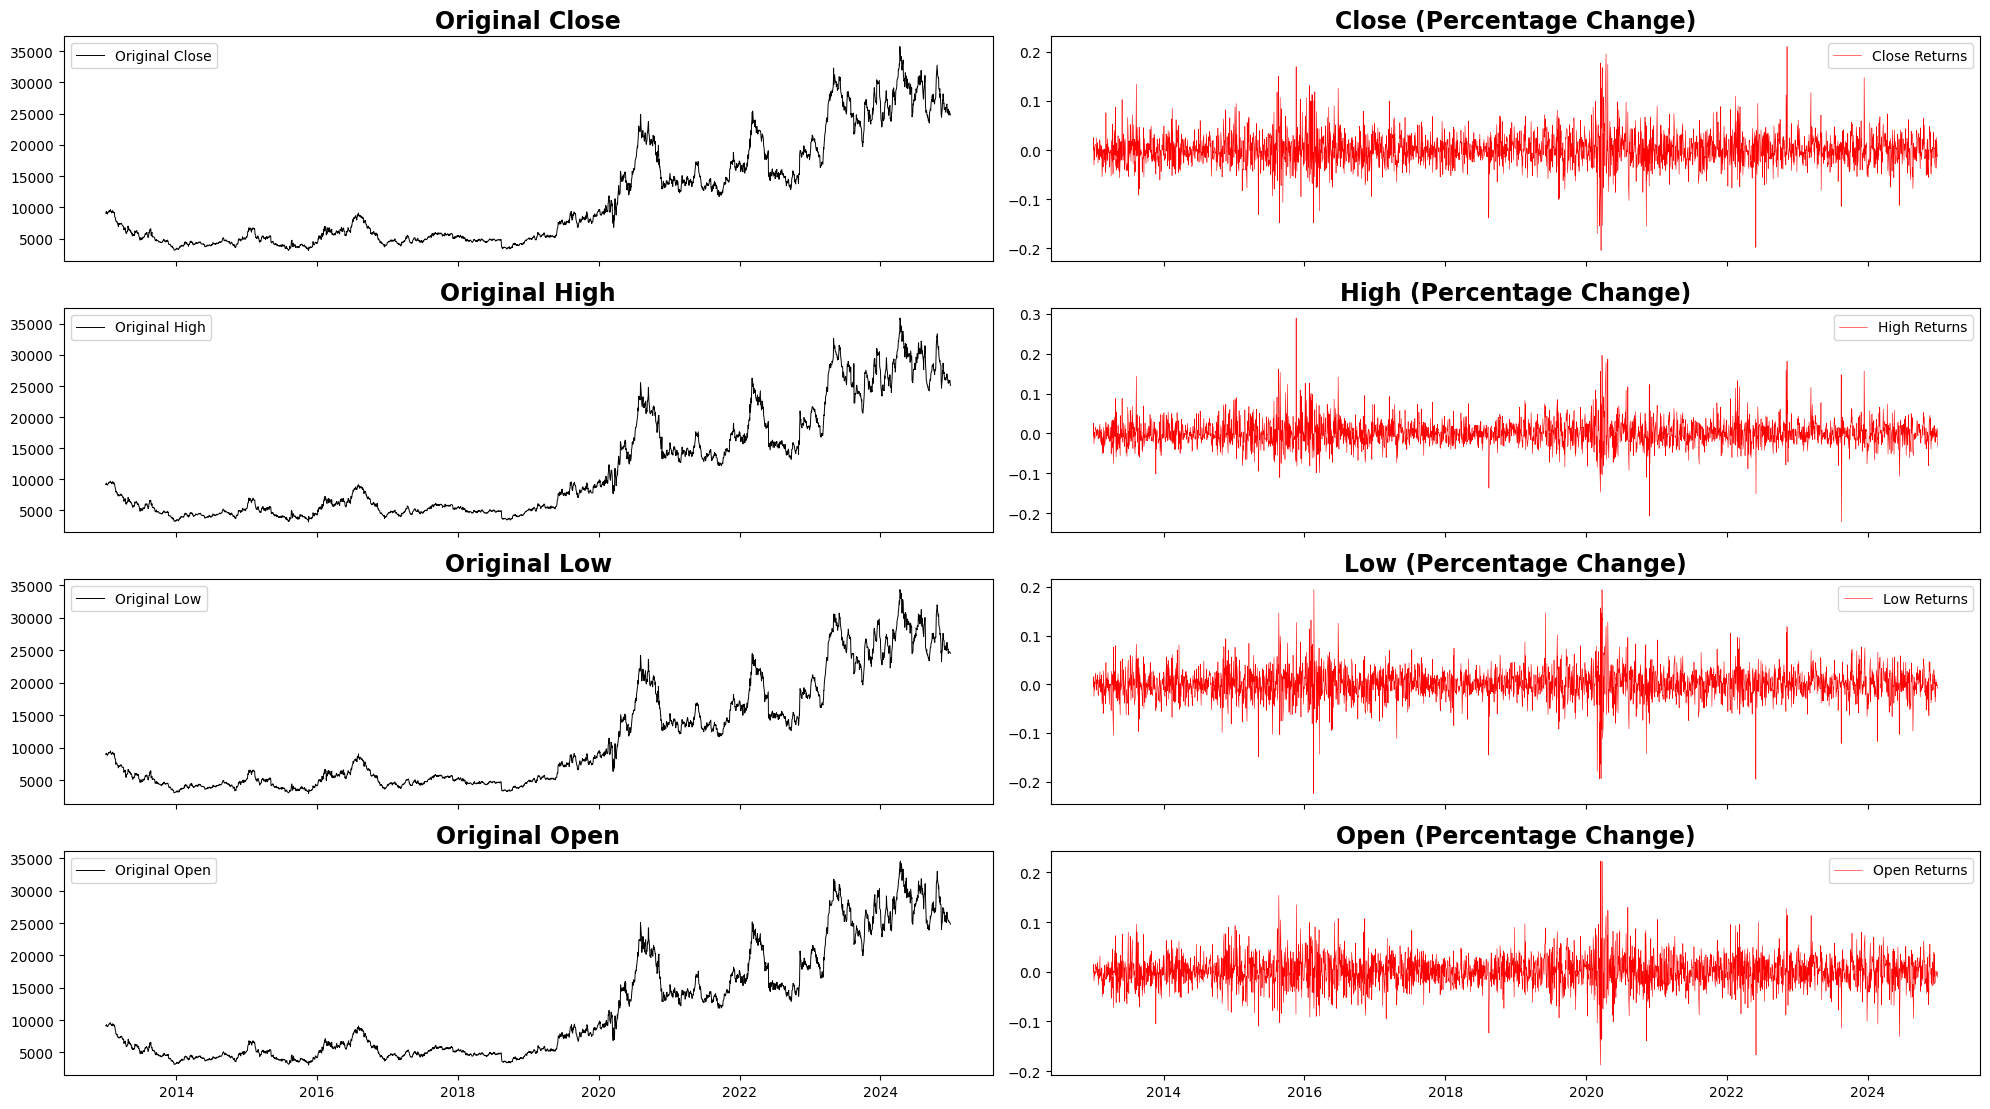

In [35]:
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(20, 2.8*n_features), sharex=True)

for i, col in enumerate(features):
    # Plot original in black, thin line
    axes[i, 0].plot(data1[col], label=f"Original {col}", color='black', linewidth=0.7)
    axes[i, 0].set_title(f"Original {col}", fontsize=17, fontweight="bold")
    axes[i, 0].legend()

    # Plot returns in red, thin line
    axes[i, 1].plot(data_returns[col], label=f"{col} Returns", color='red', linewidth=0.4)
    axes[i, 1].set_title(f"{col} (Percentage Change)", fontsize=17, fontweight="bold")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

# Same split but different naming of train/test set

SVR

In [36]:
from sklearn.preprocessing import StandardScaler

train_SVR = data_returns[data_returns.index < "2023-01-01"]
test_SVR = data_returns[data_returns.index >= "2023-01-01"]

X_train_SVR = train_SVR[["High", "Low", "Open"]]
y_train_SVR = train_SVR["Close"]

X_test_SVR = test_SVR[["High", "Low", "Open"]]
y_test_SVR = test_SVR["Close"]

print("Before scaling (SVR):")
print("Train shape (SVR):", X_train_SVR.shape, y_train_SVR.shape)
print("Test shape (SVR):", X_test_SVR.shape, y_test_SVR.shape)

scaler_SVR = StandardScaler()

X_train_scaled_SVR = scaler_SVR.fit_transform(X_train_SVR)
X_test_scaled_SVR = scaler_SVR.transform(X_test_SVR)

print("\nAfter scaling (SVR):")
print("X_train_scaled shape (SVR):", X_train_scaled_SVR.shape)
print("X_test_scaled shape (SVR):", X_test_scaled_SVR.shape)


Before scaling (SVR):
Train shape (SVR): (2551, 3) (2551,)
Test shape (SVR): (497, 3) (497,)

After scaling (SVR):
X_train_scaled shape (SVR): (2551, 3)
X_test_scaled shape (SVR): (497, 3)


In [37]:
X_scaler_SVR = StandardScaler()
y_scaler_SVR = StandardScaler()

X_train_scaled_SVR = X_scaler_SVR.fit_transform(X_train_SVR)
X_test_scaled_SVR = X_scaler_SVR.transform(X_test_SVR)

y_train_scaled_SVR = y_scaler_SVR.fit_transform(y_train_SVR.values.reshape(-1, 1)).ravel()

svr_model = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.01)
svr_model.fit(X_train_scaled_SVR, y_train_scaled_SVR)

y_pred_scaled_SVR = svr_model.predict(X_test_scaled_SVR)

y_pred_SVR = y_scaler_SVR.inverse_transform(y_pred_scaled_SVR.reshape(-1, 1)).ravel()

KNN

In [38]:
train_KNN = data_returns[data_returns.index < "2023-01-01"]
test_KNN = data_returns[data_returns.index >= "2023-01-01"]

X_train_KNN = train_KNN[["High", "Low", "Open"]]
y_train_KNN = train_KNN["Close"]

X_test_KNN = test_KNN[["High", "Low", "Open"]]
y_test_KNN = test_KNN["Close"]

print("Train shape (KNN):", X_train_KNN.shape, y_train_KNN.shape)
print("Test shape (KNN):", X_test_KNN.shape, y_test_KNN.shape)


Train shape (KNN): (2551, 3) (2551,)
Test shape (KNN): (497, 3) (497,)


RFR

In [39]:
train_RFR = data_returns[data_returns.index < "2023-01-01"]
test_RFR = data_returns[data_returns.index >= "2023-01-01"]

X_train_RFR = train_RFR[["High", "Low", "Open"]]
y_train_RFR = train_RFR["Close"]

X_test_RFR = test_RFR[["High", "Low", "Open"]]
y_test_RFR = test_RFR["Close"]

print("Before scaling (RFR):")
print("Train shape (RFR):", X_train_RFR.shape, y_train_RFR.shape)
print("Test shape (RFR):", X_test_RFR.shape, y_test_RFR.shape)

scaler_RFR = StandardScaler()

X_train_scaled_RFR = scaler_RFR.fit_transform(X_train_RFR)
X_test_scaled_RFR = scaler_RFR.transform(X_test_RFR)

print("\nAfter scaling (RFR):")
print("X_train_scaled shape (RFR):", X_train_scaled_RFR.shape)
print("X_test_scaled shape (RFR):", X_test_scaled_RFR.shape)


Before scaling (RFR):
Train shape (RFR): (2551, 3) (2551,)
Test shape (RFR): (497, 3) (497,)

After scaling (RFR):
X_train_scaled shape (RFR): (2551, 3)
X_test_scaled shape (RFR): (497, 3)


XGBOOST

In [40]:
train_XGB = data_returns[data_returns.index < "2023-01-01"]
test_XGB = data_returns[data_returns.index >= "2023-01-01"]

X_train_XGB = train_XGB[["High", "Low", "Open"]]
y_train_XGB = train_XGB["Close"]

X_test_XGB = test_XGB[["High", "Low", "Open"]]
y_test_XGB = test_XGB["Close"]

print("Before scaling (XGB):")
print("Train shape (XGB):", X_train_XGB.shape, y_train_XGB.shape)
print("Test shape (XGB):", X_test_XGB.shape, y_test_XGB.shape)

scaler_XGB = StandardScaler()

X_train_scaled_XGB = scaler_XGB.fit_transform(X_train_XGB)
X_test_scaled_XGB = scaler_XGB.transform(X_test_XGB)

print("\nAfter scaling (XGB):")
print("X_train_scaled shape (XGB):", X_train_scaled_XGB.shape)
print("X_test_scaled shape (XGB):", X_test_scaled_XGB.shape)

Before scaling (XGB):
Train shape (XGB): (2551, 3) (2551,)
Test shape (XGB): (497, 3) (497,)

After scaling (XGB):
X_train_scaled shape (XGB): (2551, 3)
X_test_scaled shape (XGB): (497, 3)


# Models training

In [41]:
# Helper function for metrics
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = (100/len(y_true)) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
    r2 = r2_score(y_true, y_pred)

    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE%": mape,
        "SMAPE%": smape,
        "R²": r2
    }

results = []

# 1. KNN
knn_model_KNN = KNeighborsRegressor(n_neighbors=13)
knn_model_KNN.fit(X_train_KNN, y_train_KNN)
y_pred_KNN = knn_model_KNN.predict(X_test_KNN)
results.append(evaluate_model(y_test_KNN, y_pred_KNN, "KNN"))

#SVR
param_grid = {
    'kernel': ['rbf'],                 # SVR usually best with RBF
    'C': [1, 10, 100],                 # regularization strength
    'gamma': ['scale', 0.01, 0.1],     # kernel coefficient
    'epsilon': [0.01, 0.1, 0.5]        # error tolerance
}

grid_search_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

grid_search_svr.fit(X_train_scaled_SVR, y_train_scaled_SVR)
best_svr = grid_search_svr.best_estimator_
y_pred_scaled_SVR = best_svr.predict(X_test_scaled_SVR)
y_pred_SVR = y_scaler_SVR.inverse_transform(y_pred_scaled_SVR.reshape(-1, 1)).ravel()
results.append(evaluate_model(y_test_SVR, y_pred_SVR, "SVR"))

#RFR
param_grid = {
    'n_estimators': [100, 300],        # fewer tree options
    'max_depth': [None, 20],           # shallow vs deep
    'min_samples_split': [2, 5],       # common splits
    'min_samples_leaf': [1, 2],        # typical leaf sizes
    'max_features': ['sqrt']           # most common choice for RF
}

# Setup GridSearchCV
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,                      # fewer folds to reduce fits
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

grid_search_rfr.fit(X_train_scaled_RFR, y_train_RFR)
best_rfr = grid_search_rfr.best_estimator_
y_pred_RFR = best_rfr.predict(X_test_scaled_RFR)
results.append(evaluate_model(y_test_RFR, y_pred_RFR, "RFR"))

# 4. XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameter grid (small to keep fits reasonable)
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setup GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,   # fewer folds for speed
    scoring='neg_mean_squared_error',
    verbose=0
)

grid_search_xgb.fit(X_train_scaled_XGB, y_train_XGB)
best_xgb = grid_search_xgb.best_estimator_
y_pred_XGB = best_xgb.predict(X_test_scaled_XGB)
results.append(evaluate_model(y_test_XGB, y_pred_XGB, "XGB"))
results_df_XGB = pd.DataFrame(results)
display(results_df_XGB)



,Model,RMSE,MAE,MAPE%,SMAPE%,R²
0,KNN,0.015794,0.011793,173.163943,93.521053,0.683014
1,SVR,0.015899,0.011947,186.838459,92.211632,0.678807
2,RFR,0.015594,0.011858,172.754086,93.980714,0.691013
3,XGB,0.015694,0.011720,175.721660,91.634059,0.687034


# Plot of actual vs forecasted (Stationary)

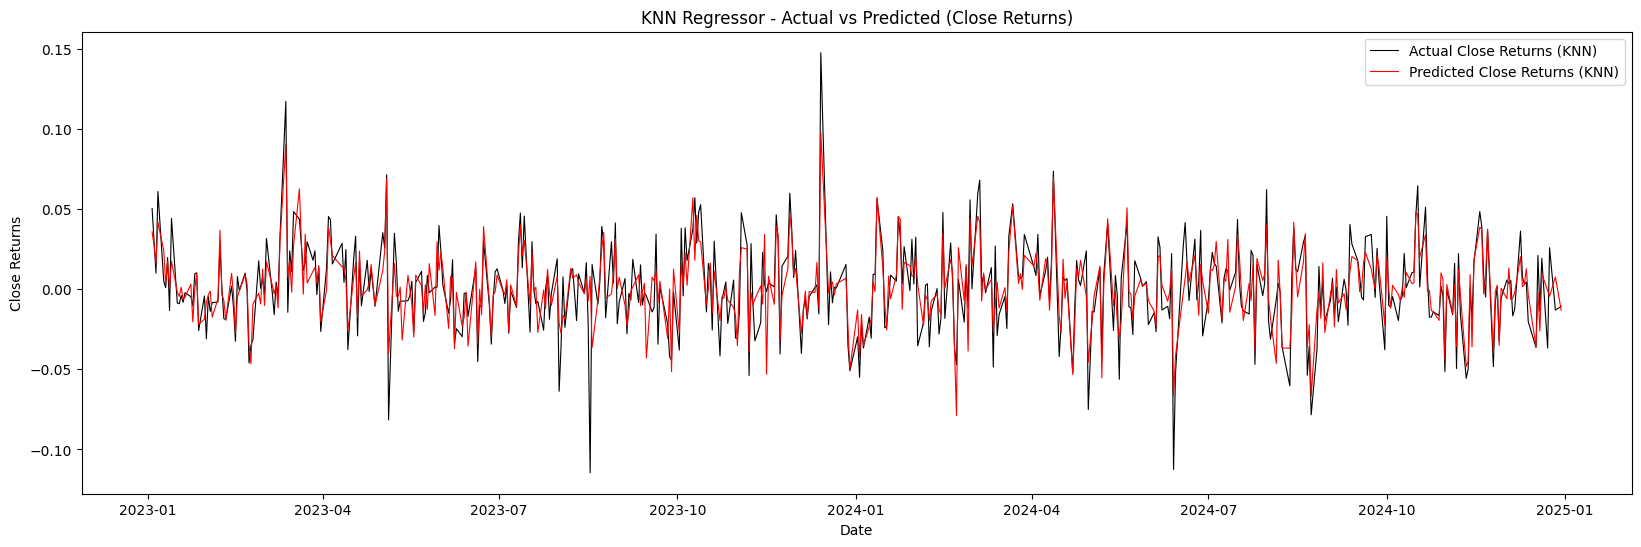

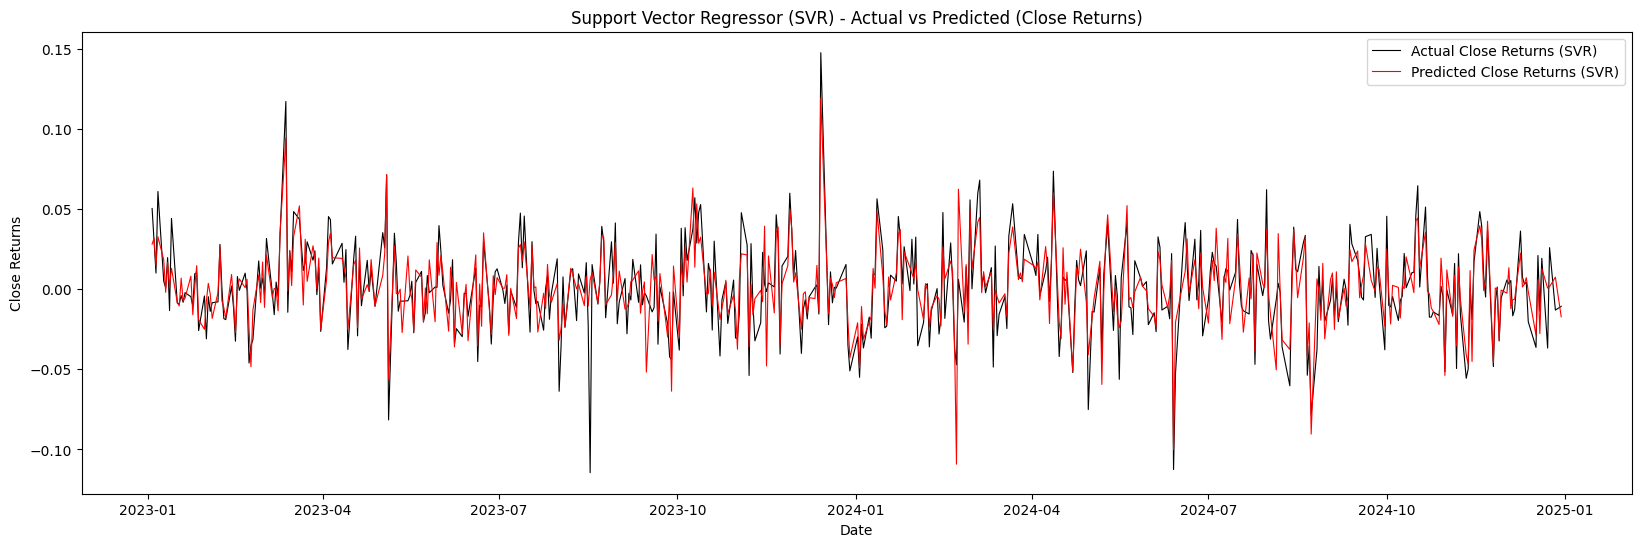

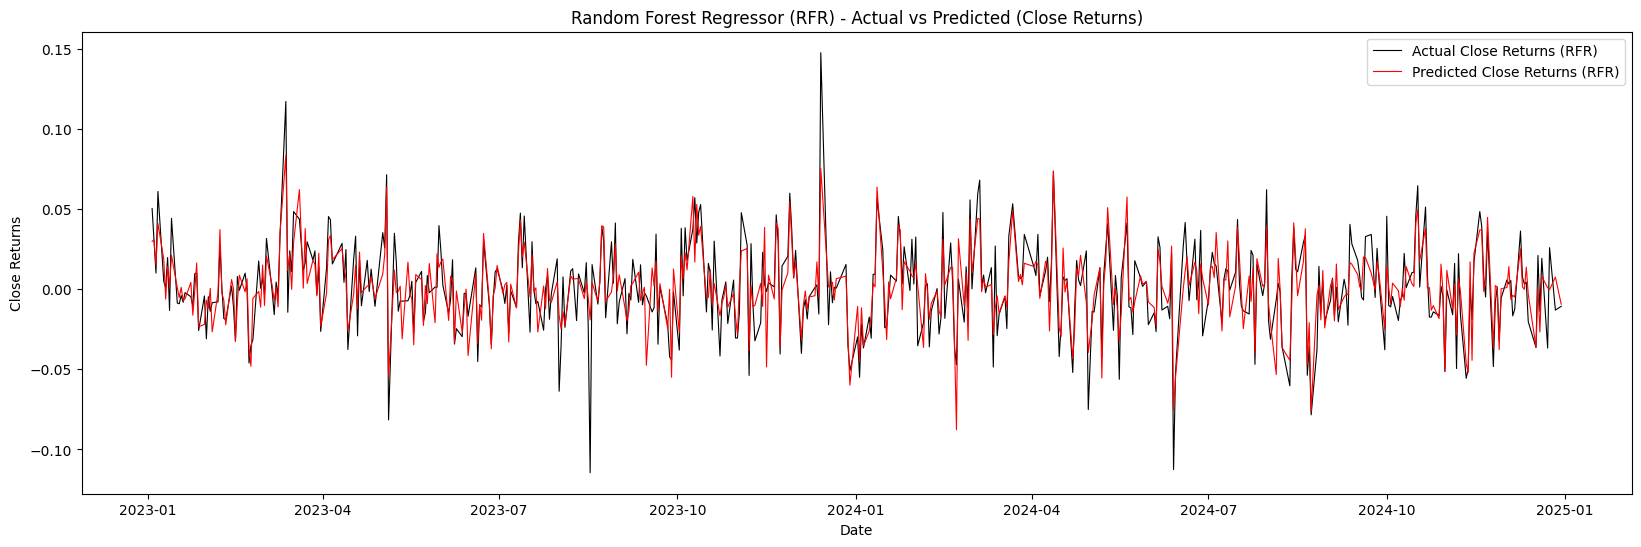

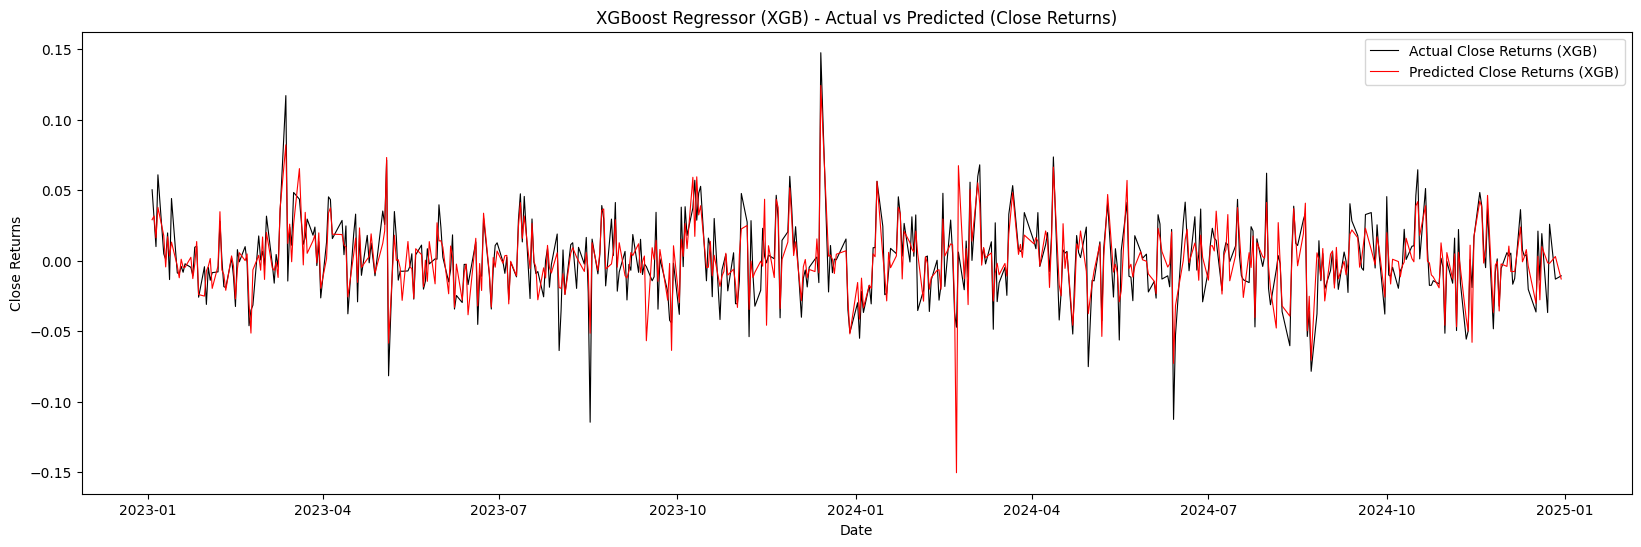

In [42]:
# KNN
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(y_test_KNN.index, y_test_KNN,
         label="Actual Close Returns (KNN)",
         color="black", linewidth=0.8)
plt.plot(y_test_KNN.index, y_pred_KNN,
         label="Predicted Close Returns (KNN)",
         color="red", linewidth=0.8)
plt.title("KNN Regressor - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

# SVR
plt.figure(figsize=(20, 6))
plt.plot(y_test_SVR.index, y_test_SVR,
         label="Actual Close Returns (SVR)",
         color="black", linewidth=0.8)
plt.plot(y_test_SVR.index, y_pred_SVR,
         label="Predicted Close Returns (SVR)",
         color="red", linewidth=0.8)
plt.title("Support Vector Regressor (SVR) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


#RFR
plt.figure(figsize=(20, 6))
plt.plot(y_test_RFR.index, y_test_RFR,
         label="Actual Close Returns (RFR)",
         color="black", linewidth=0.8)
plt.plot(y_test_RFR.index, y_pred_RFR,
         label="Predicted Close Returns (RFR)",
         color="red", linewidth=0.8)
plt.title("Random Forest Regressor (RFR) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#XGBOOST

plt.figure(figsize=(20, 6))
plt.plot(y_test_XGB.index, y_test_XGB,
         label="Actual Close Returns (XGB)",
         color="black", linewidth=0.8)
plt.plot(y_test_XGB.index, y_pred_XGB,
         label="Predicted Close Returns (XGB)",
         color="red",linewidth=0.8 )
plt.title("XGBoost Regressor (XGB) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


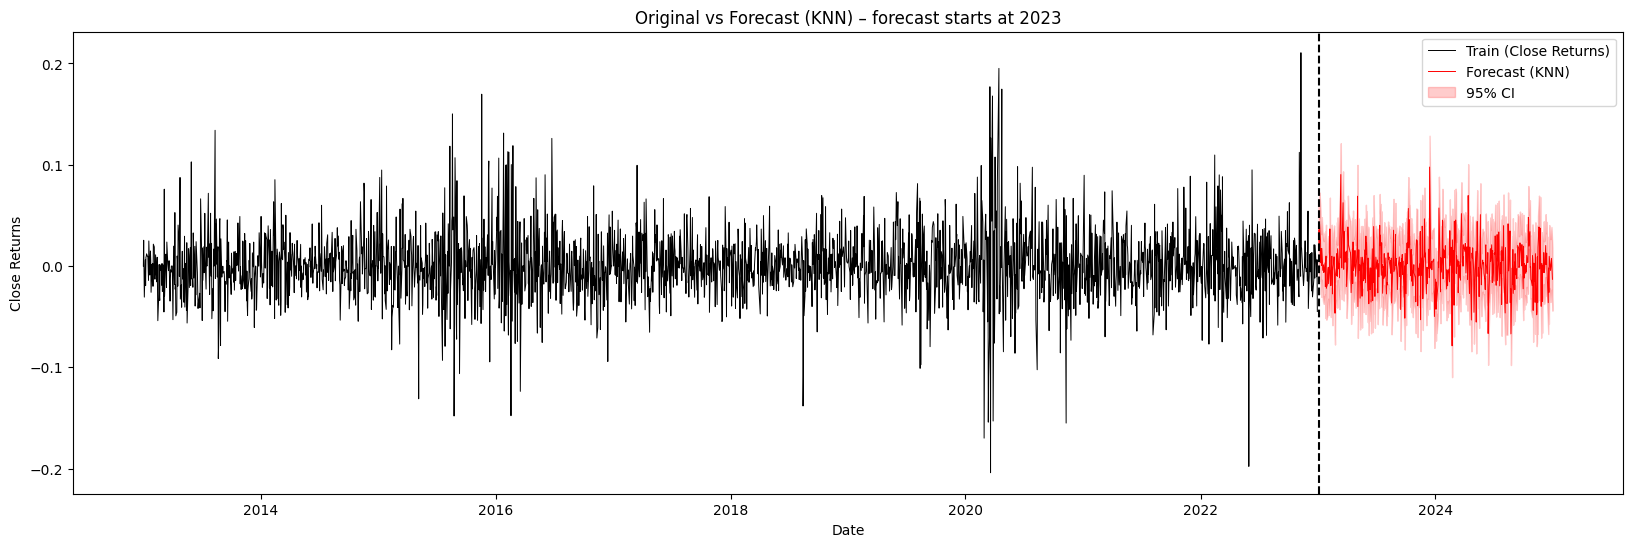

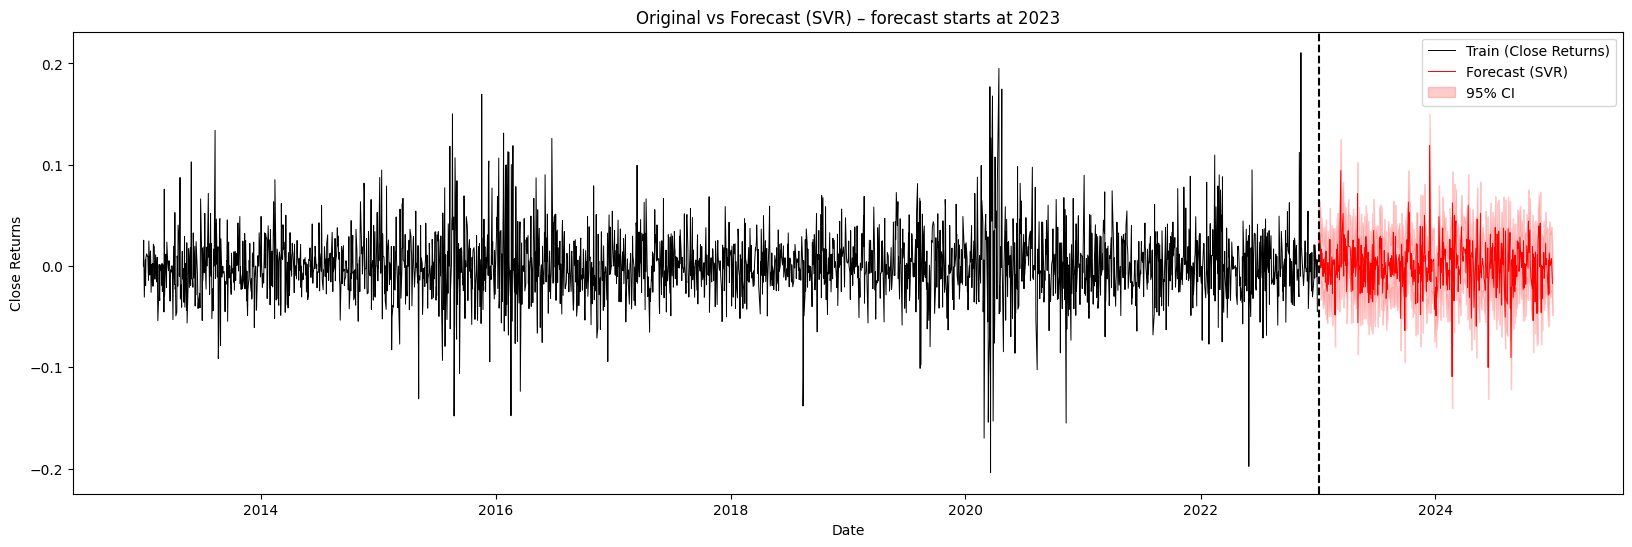

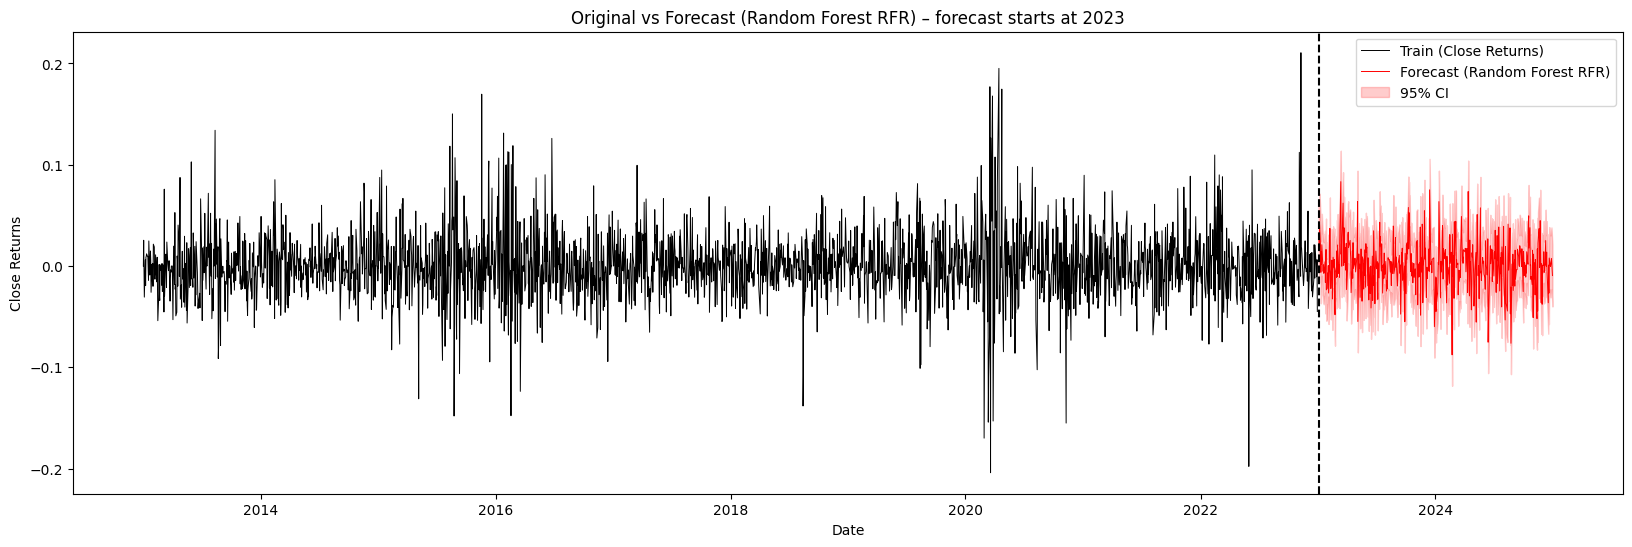

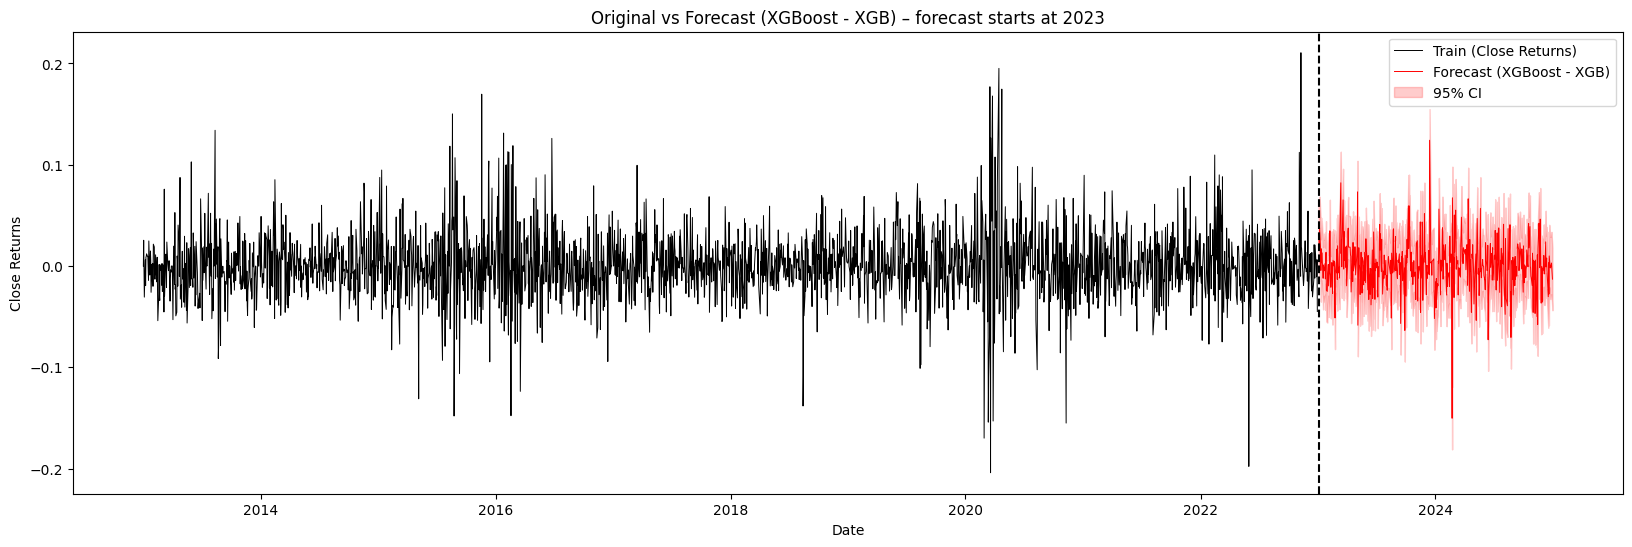

In [43]:
#KNN

error_KNN = y_test_KNN.values - y_pred_KNN
err_std_KNN = np.std(error_KNN)
lower_KNN = y_pred_KNN - 1.96 * err_std_KNN
upper_KNN = y_pred_KNN + 1.96 * err_std_KNN

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(X_train_KNN.index, y_train_KNN.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_KNN.index, y_pred_KNN, label="Forecast (KNN)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_KNN.index, lower_KNN, upper_KNN, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_KNN.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (KNN) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#SVR
# Error and confidence interval (make sure y_pred is inverse transformed)
error_SVR = y_test_SVR.values - y_pred_SVR
err_std_SVR = np.std(error_SVR)
lower_SVR = y_pred_SVR - 1.96 * err_std_SVR
upper_SVR = y_pred_SVR + 1.96 * err_std_SVR

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(X_train_SVR.index, y_train_SVR.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_SVR.index, y_pred_SVR, label="Forecast (SVR)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_SVR.index, lower_SVR, upper_SVR, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_SVR.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (SVR) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#RF
# Error and confidence interval
error_RFR = y_test_RFR.values - y_pred_RFR
err_std_RFR = np.std(error_RFR)
lower_RFR = y_pred_RFR - 1.96 * err_std_RFR
upper_RFR = y_pred_RFR + 1.96 * err_std_RFR

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(X_train_RFR.index, y_train_RFR.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_RFR.index, y_pred_RFR, label="Forecast (Random Forest RFR)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_RFR.index, lower_RFR, upper_RFR, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_RFR.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (Random Forest RFR) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


#XGBOOST
# Error and confidence interval (make sure y_pred_XGB is inverse transformed if needed)
error_XGB = y_test_XGB.values - y_pred_XGB
err_std_XGB = np.std(error_XGB)
lower_XGB = y_pred_XGB - 1.96 * err_std_XGB
upper_XGB = y_pred_XGB + 1.96 * err_std_XGB

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(y_train_XGB.index, y_train_XGB.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_XGB.index, y_pred_XGB, label="Forecast (XGBoost - XGB)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_XGB.index, lower_XGB, upper_XGB, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_XGB.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (XGBoost - XGB) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


#Learning curves

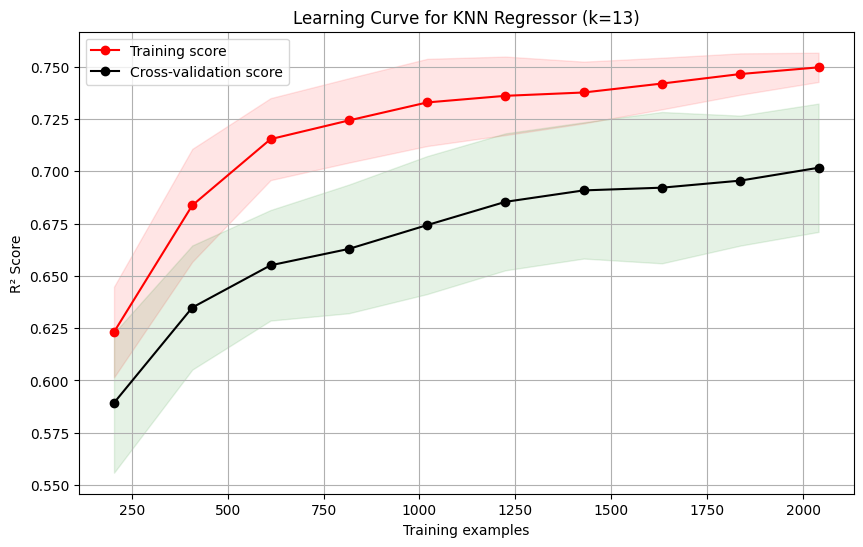

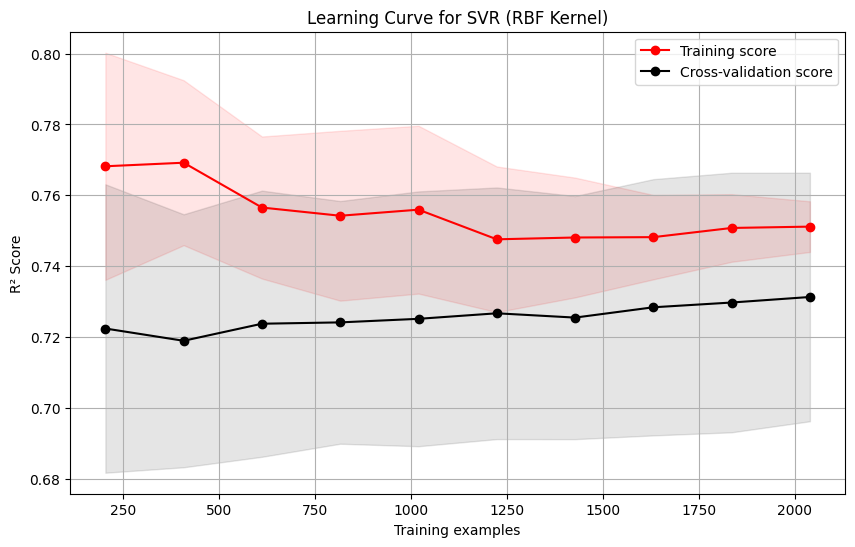

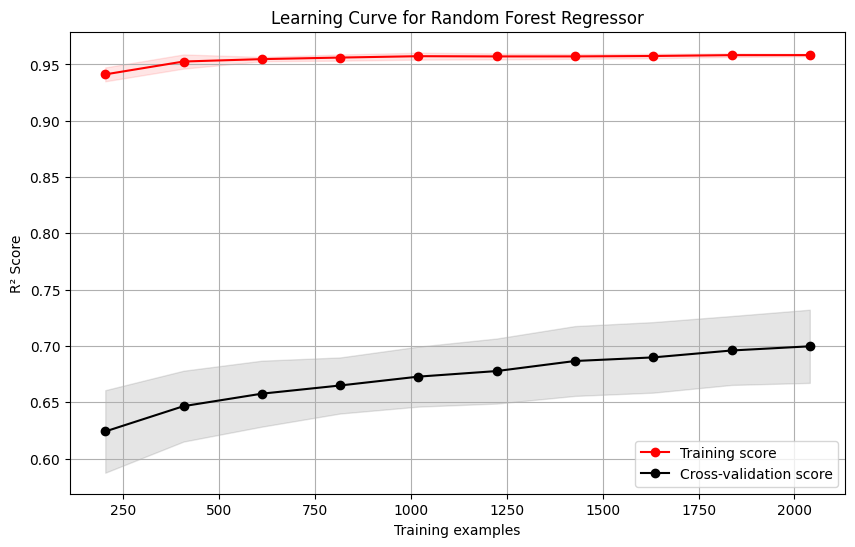

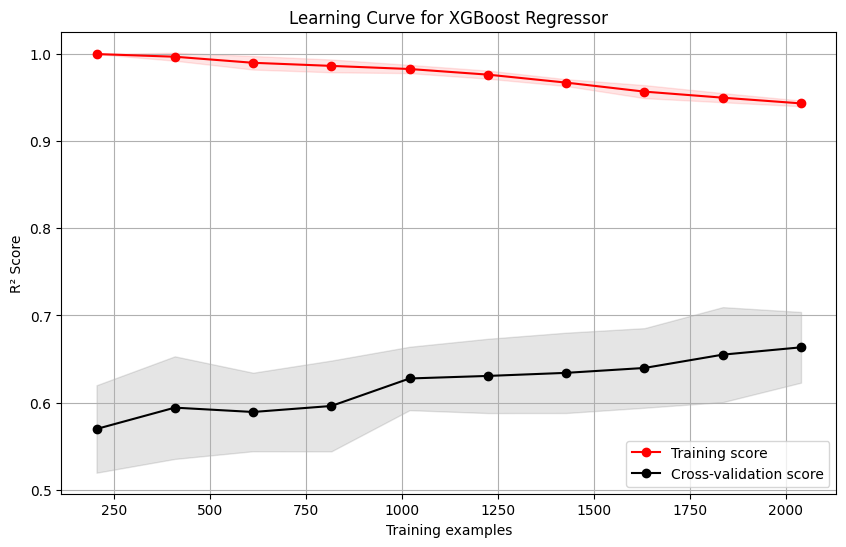

In [44]:
#KNN
knn_model = KNeighborsRegressor(n_neighbors=13)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_model,
    X=X_train_KNN,
    y=y_train_KNN,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="k", label="Cross-validation score")

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="r")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color="g")

plt.title("Learning Curve for KNN Regressor (k=13)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

#SVR
svr_model = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.01)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=svr_model,
    X=X_train_scaled_SVR,
    y=y_train_scaled_SVR,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="k", label="Cross-validation score")  # black line for CV

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="r")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color="k")

plt.title("Learning Curve for SVR (RBF Kernel)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

#RFR
rfr_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rfr_model,
    X=X_train_scaled_RFR,
    y=y_train_RFR,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="k", label="Cross-validation score")  # black line for CV

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="r")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color="k")

plt.title("Learning Curve for Random Forest Regressor")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

#XGB
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_model,
    X=X_train_scaled_XGB,
    y=y_train_XGB,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="k", label="Cross-validation score")  # black line for CV

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="r")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color="k")

plt.title("Learning Curve for XGBoost Regressor")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


#CM of actual vs forecasted up/down

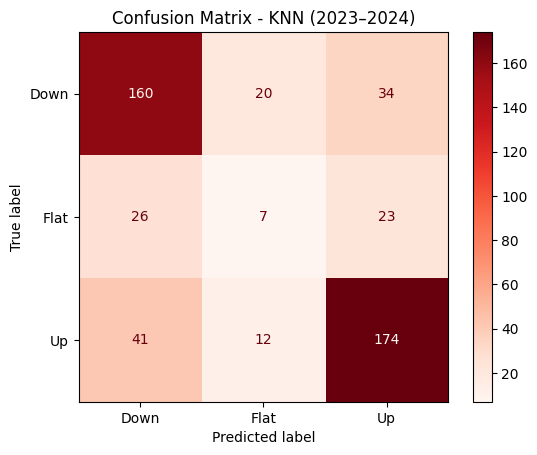

Classification Report - KNN
              precision    recall  f1-score   support

        Down       0.70      0.75      0.73       214
        Flat       0.18      0.12      0.15        56
          Up       0.75      0.77      0.76       227

    accuracy                           0.69       497
   macro avg       0.55      0.55      0.54       497
weighted avg       0.67      0.69      0.68       497



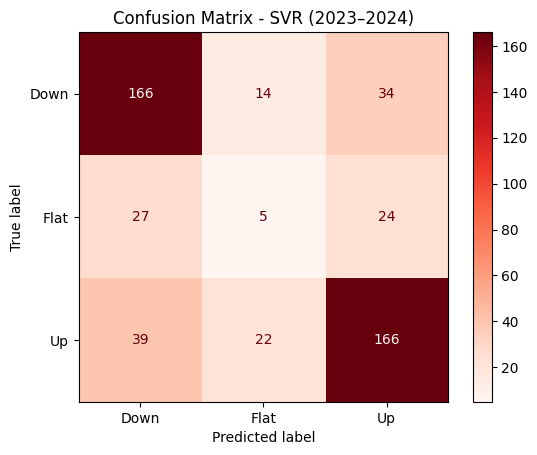

Classification Report - SVR
              precision    recall  f1-score   support

        Down       0.72      0.78      0.74       214
        Flat       0.12      0.09      0.10        56
          Up       0.74      0.73      0.74       227

    accuracy                           0.68       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.66      0.68      0.67       497



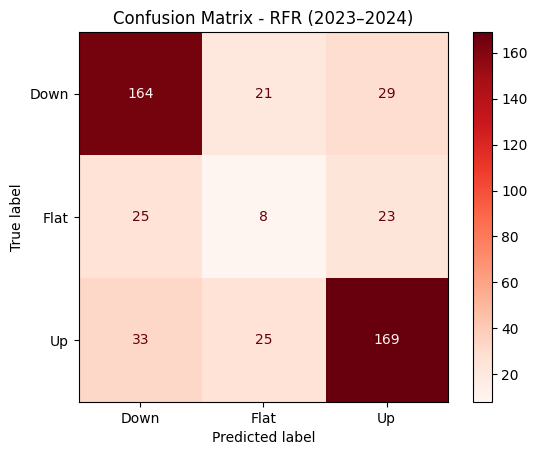

Classification Report - Random Forest (RFR)
              precision    recall  f1-score   support

        Down       0.74      0.77      0.75       214
        Flat       0.15      0.14      0.15        56
          Up       0.76      0.74      0.75       227

    accuracy                           0.69       497
   macro avg       0.55      0.55      0.55       497
weighted avg       0.68      0.69      0.68       497



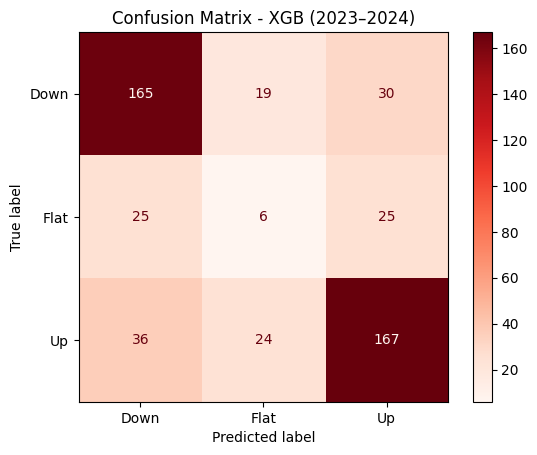

Classification Report - XGBoost (XGB)
              precision    recall  f1-score   support

        Down       0.73      0.77      0.75       214
        Flat       0.12      0.11      0.11        56
          Up       0.75      0.74      0.74       227

    accuracy                           0.68       497
   macro avg       0.53      0.54      0.54       497
weighted avg       0.67      0.68      0.68       497



In [45]:
#KNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_test_arr_KNN = np.array(y_test_KNN).flatten()
y_pred_arr_KNN = np.array(y_pred_KNN).flatten()

def to_class_KNN(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

delta_true_KNN = np.diff(y_test_arr_KNN, prepend=y_test_arr_KNN[0])
delta_pred_KNN = np.diff(y_pred_arr_KNN, prepend=y_pred_arr_KNN[0])

true_cls_KNN = to_class_KNN(delta_true_KNN)
pred_cls_KNN = to_class_KNN(delta_pred_KNN)

labels_KNN = [-1, 0, 1]  # Down, Flat, Up
cm_KNN = confusion_matrix(true_cls_KNN, pred_cls_KNN, labels=labels_KNN)

disp_KNN = ConfusionMatrixDisplay(confusion_matrix=cm_KNN, display_labels=["Down", "Flat", "Up"])
disp_KNN.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - KNN (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - KNN")
print(classification_report(true_cls_KNN, pred_cls_KNN, target_names=["Down", "Flat", "Up"]))


#SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_test_arr_SVR = np.array(y_test_SVR).flatten()
y_pred_arr_SVR = np.array(y_pred_SVR).flatten()

def to_class_SVR(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

delta_true_SVR = np.diff(y_test_arr_SVR, prepend=y_test_arr_SVR[0])
delta_pred_SVR = np.diff(y_pred_arr_SVR, prepend=y_pred_arr_SVR[0])

true_cls_SVR = to_class_SVR(delta_true_SVR)
pred_cls_SVR = to_class_SVR(delta_pred_SVR)

labels_SVR = [-1, 0, 1]  # Down, Flat, Up
cm_SVR = confusion_matrix(true_cls_SVR, pred_cls_SVR, labels=labels_SVR)

disp_SVR = ConfusionMatrixDisplay(confusion_matrix=cm_SVR, display_labels=["Down", "Flat", "Up"])
disp_SVR.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - SVR (2023–2024)")
plt.show()

print("Classification Report - SVR")
print(classification_report(true_cls_SVR, pred_cls_SVR, target_names=["Down", "Flat", "Up"]))

#RF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_test_arr_RFR = np.array(y_test_RFR).flatten()
y_pred_arr_RFR = np.array(y_pred_RFR).flatten()

def to_class_RFR(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

delta_true_RFR = np.diff(y_test_arr_RFR, prepend=y_test_arr_RFR[0])
delta_pred_RFR = np.diff(y_pred_arr_RFR, prepend=y_pred_arr_RFR[0])

true_cls_RFR = to_class_RFR(delta_true_RFR)
pred_cls_RFR = to_class_RFR(delta_pred_RFR)

labels_RFR = [-1, 0, 1]  # Down, Flat, Up
cm_RFR = confusion_matrix(true_cls_RFR, pred_cls_RFR, labels=labels_RFR)

disp_RFR = ConfusionMatrixDisplay(confusion_matrix=cm_RFR, display_labels=["Down", "Flat", "Up"])
disp_RFR.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - RFR (2023–2024)")
plt.show()

print("Classification Report - Random Forest (RFR)")
print(classification_report(true_cls_RFR, pred_cls_RFR, target_names=["Down", "Flat", "Up"]))

#XGBOOST
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_test_arr_XGB = np.array(y_test_XGB).flatten()
y_pred_arr_XGB = np.array(y_pred_XGB).flatten()

def to_class_XGB(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

delta_true_XGB = np.diff(y_test_arr_XGB, prepend=y_test_arr_XGB[0])
delta_pred_XGB = np.diff(y_pred_arr_XGB, prepend=y_pred_arr_XGB[0])

true_cls_XGB = to_class_XGB(delta_true_XGB)
pred_cls_XGB = to_class_XGB(delta_pred_XGB)

labels_XGB = [-1, 0, 1]  # Down, Flat, Up
cm_XGB = confusion_matrix(true_cls_XGB, pred_cls_XGB, labels=labels_XGB)

disp_XGB = ConfusionMatrixDisplay(confusion_matrix=cm_XGB, display_labels=["Down", "Flat", "Up"])
disp_XGB.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - XGB (2023–2024)")
plt.show()

print("Classification Report - XGBoost (XGB)")
print(classification_report(true_cls_XGB, pred_cls_XGB, target_names=["Down", "Flat", "Up"]))


#Reverse engineering of forecasted stationary data and Plot of actual vs forecasted

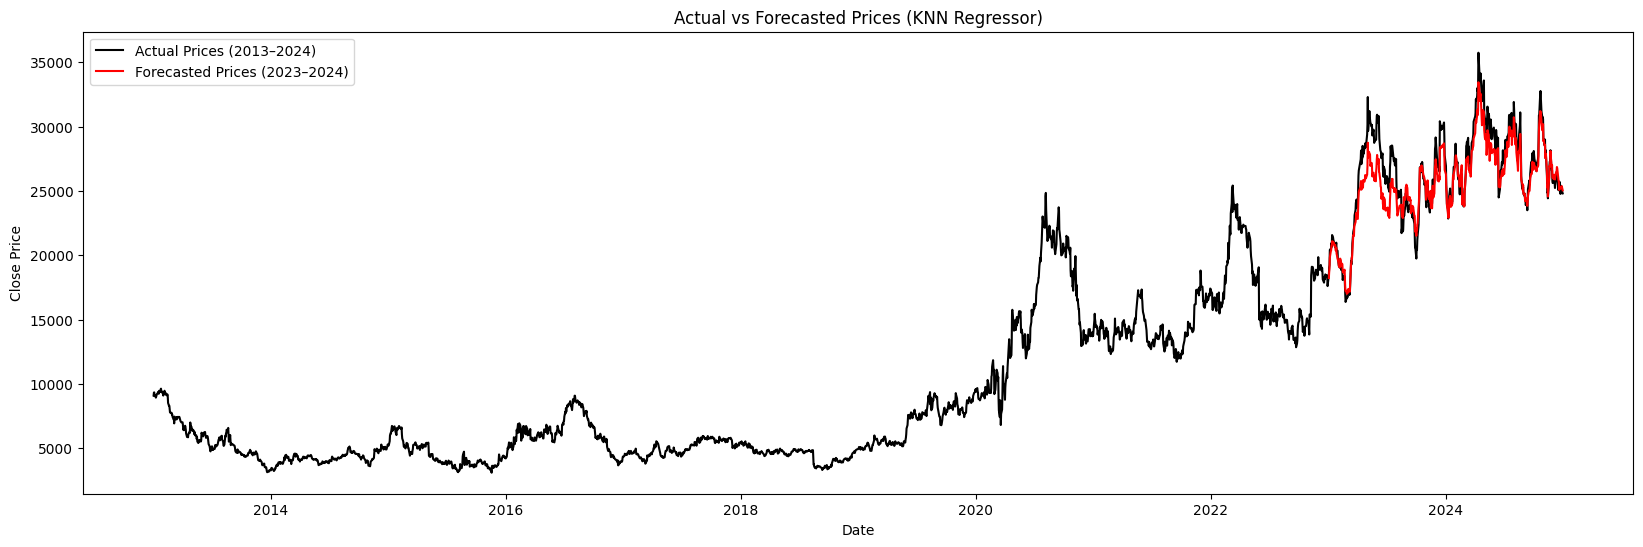

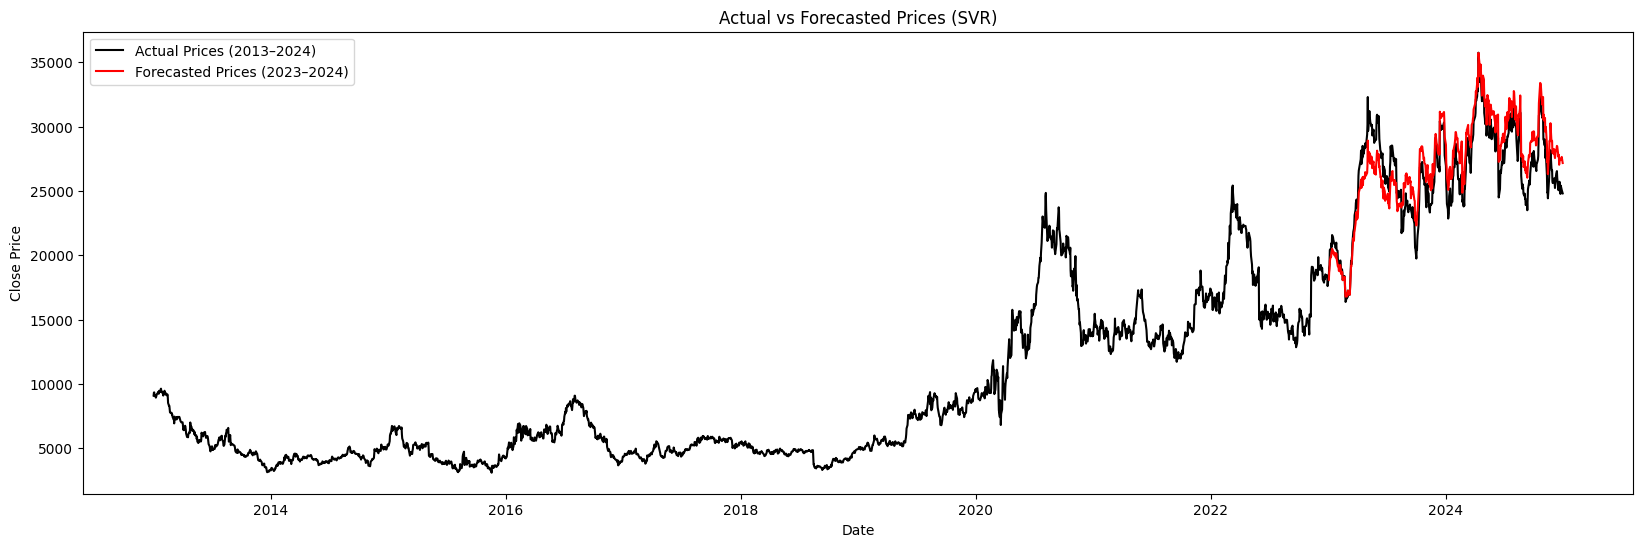

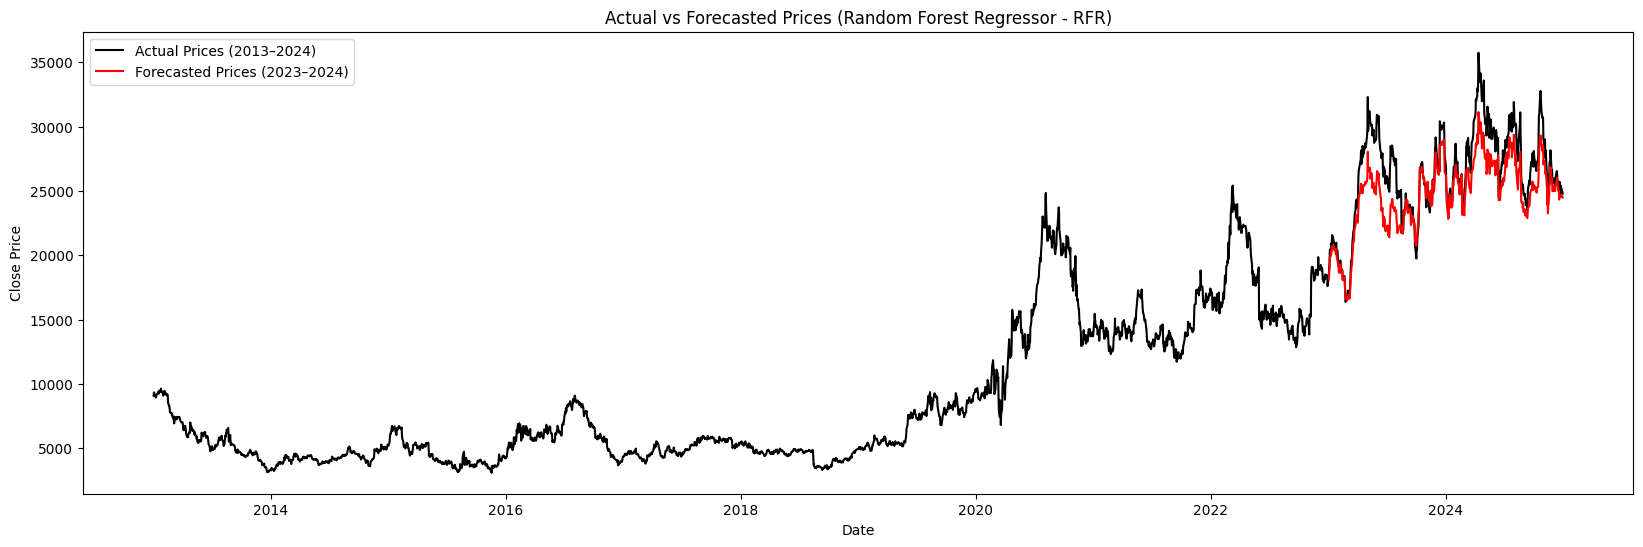

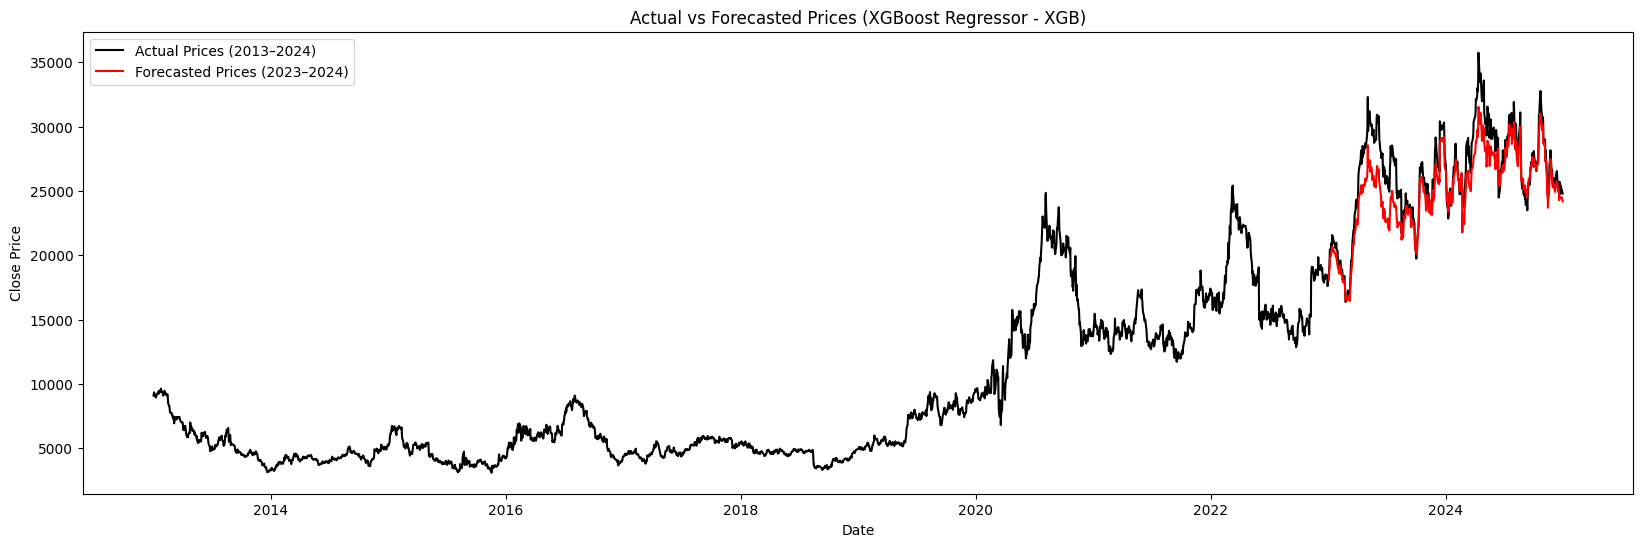

In [46]:
#KNN
P0_KNN = data1["Close"].iloc[0]
reconstructed_prices_KNN = (1 + data_returns["Close"]).cumprod() * P0_KNN

last_price_2022_KNN = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

forecast_prices_KNN = (1 + pd.Series(y_pred_KNN, index=y_test_KNN.index)).cumprod() * last_price_2022_KNN

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.plot(reconstructed_prices_KNN.index, reconstructed_prices_KNN,
         label="Actual Prices (2013–2024)", color="black")

plt.plot(forecast_prices_KNN.index, forecast_prices_KNN,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (KNN Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


#SVR
p0_SVR = data1["Close"].iloc[0]
reconstructed_prices_SVR = (1 + data_returns["Close"]).cumprod() * p0_SVR

last_price_2022_SVR = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

forecast_prices_SVR = (1 + pd.Series(y_pred_SVR, index=y_test_SVR.index)).cumprod() * last_price_2022_SVR

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.plot(reconstructed_prices_SVR.index, reconstructed_prices_SVR,
         label="Actual Prices (2013–2024)", color="black")

plt.plot(forecast_prices_SVR.index, forecast_prices_SVR,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (SVR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#RF
P0_RFR = data1["Close"].iloc[0]
reconstructed_prices_RFR = (1 + data_returns["Close"]).cumprod() * P0_RFR

last_price_2022_RFR = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

forecast_prices_RFR = (1 + pd.Series(y_pred_RFR, index=y_test_RFR.index)).cumprod() * last_price_2022_RFR

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.plot(reconstructed_prices_RFR.index, reconstructed_prices_RFR,
         label="Actual Prices (2013–2024)", color="black")

plt.plot(forecast_prices_RFR.index, forecast_prices_RFR,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (Random Forest Regressor - RFR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


#XGBOOST
P0_XGB = data1["Close"].iloc[0]
reconstructed_prices_XGB = (1 + data_returns["Close"]).cumprod() * P0_XGB

last_price_2022_XGB = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

forecast_prices_XGB = (1 + pd.Series(y_pred_XGB, index=y_test_XGB.index)).cumprod() * last_price_2022_XGB

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.plot(reconstructed_prices_XGB.index, reconstructed_prices_XGB,
         label="Actual Prices (2013–2024)", color="black")

plt.plot(forecast_prices_XGB.index, forecast_prices_XGB,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (XGBoost Regressor - XGB)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


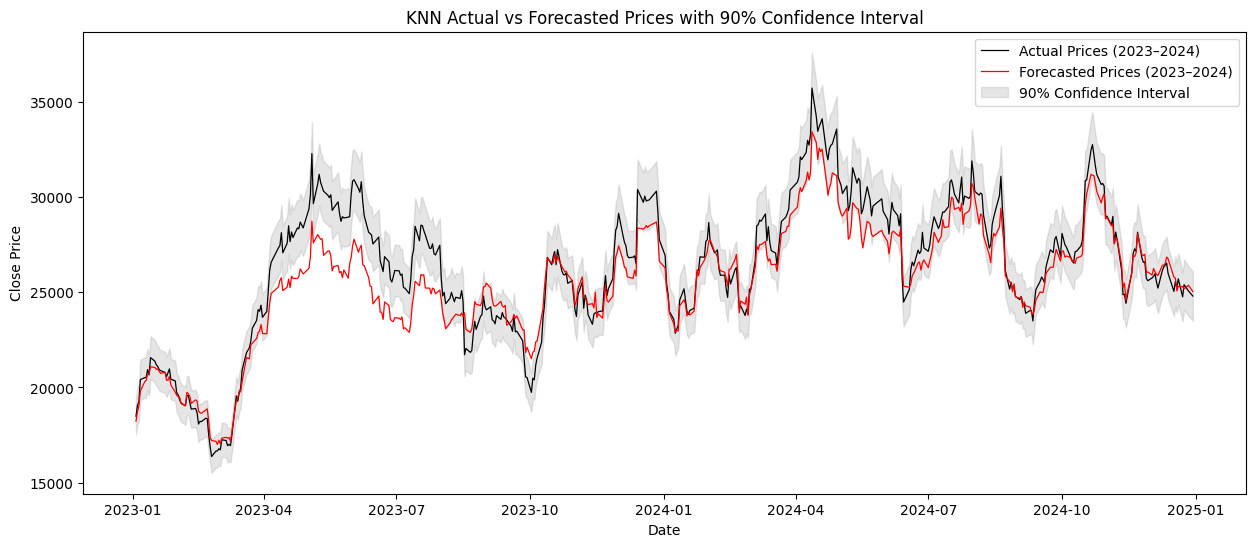

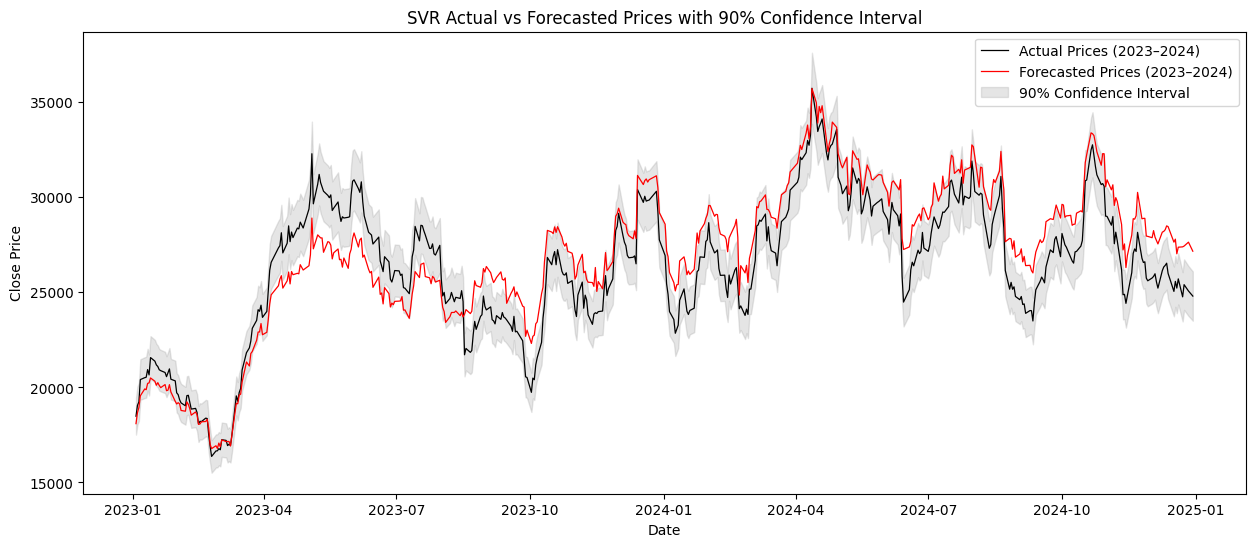

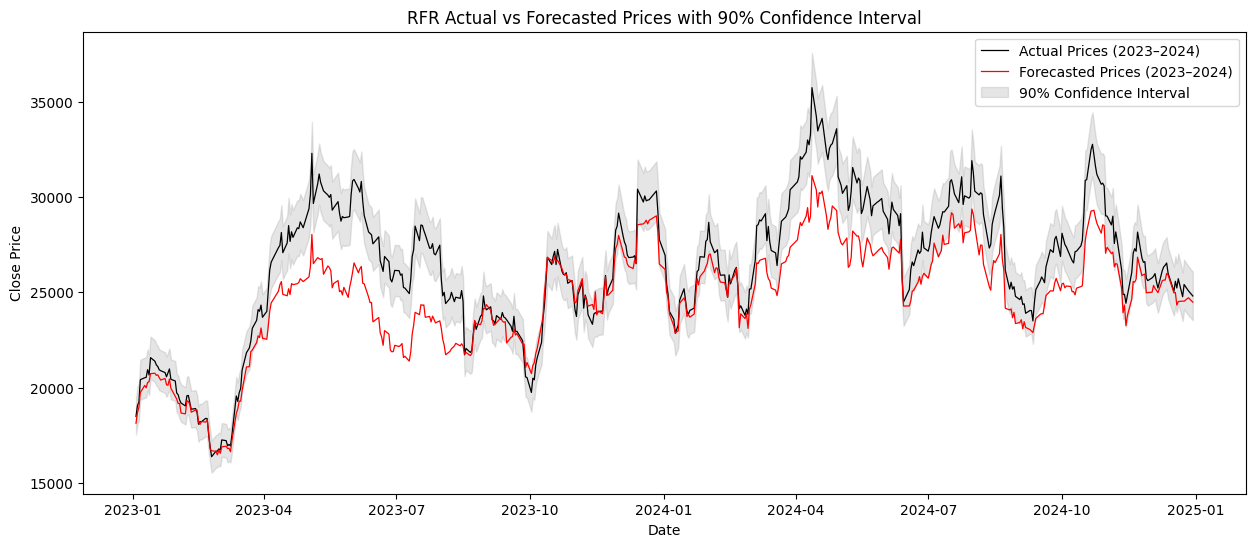

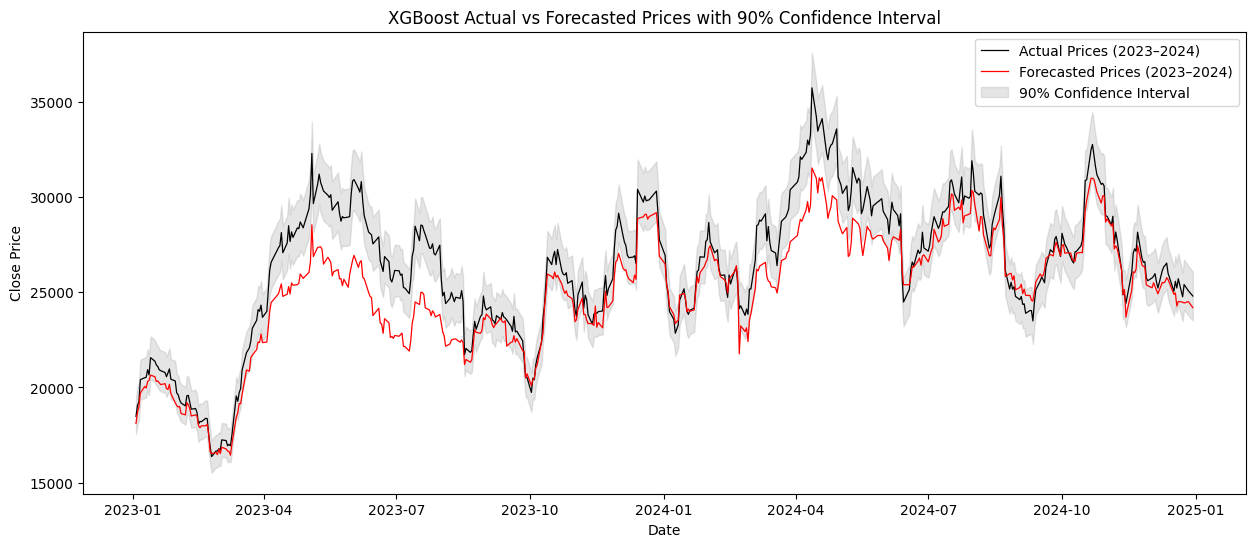

In [47]:
# KNN
residuals_KNN = y_test_KNN - y_pred_KNN
std_resid_KNN = np.std(residuals_KNN)

z_90 = 1.645

actual_trimmed_KNN = reconstructed_prices_KNN.loc[forecast_prices_KNN.index]

ci_band = z_90 * std_resid_KNN * actual_trimmed_KNN * 2

upper_bound = actual_trimmed_KNN + ci_band
lower_bound = actual_trimmed_KNN - ci_band

plt.figure(figsize=(15, 6))

plt.plot(actual_trimmed_KNN.index, actual_trimmed_KNN,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

plt.plot(forecast_prices_KNN.index, forecast_prices_KNN,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

plt.fill_between(actual_trimmed_KNN.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2,
                 label="90% Confidence Interval")

plt.title("KNN Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#SVR
residuals_SVR = y_test_SVR - y_pred_SVR
std_resid_SVR = np.std(residuals_SVR)

z_90 = 1.645

actual_trimmed_SVR = reconstructed_prices_SVR.loc[forecast_prices_SVR.index]

ci_band = z_90 * std_resid_SVR * actual_trimmed_SVR * 2

upper_bound = actual_trimmed_SVR + ci_band
lower_bound = actual_trimmed_SVR - ci_band

plt.figure(figsize=(15, 6))

plt.plot(actual_trimmed_SVR.index, actual_trimmed_SVR,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

plt.plot(forecast_prices_SVR.index, forecast_prices_SVR,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

plt.fill_between(actual_trimmed_SVR.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2,
                 label="90% Confidence Interval")

plt.title("SVR Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#RFR
residuals_RFR = y_test_RFR - y_pred_RFR
std_resid_RFR = np.std(residuals_RFR)

z_90 = 1.645

actual_trimmed = reconstructed_prices_RFR.loc[forecast_prices_RFR.index]

ci_band = z_90 * std_resid_RFR * actual_trimmed * 2

upper_bound = actual_trimmed + ci_band
lower_bound = actual_trimmed - ci_band

plt.figure(figsize=(15, 6))

plt.plot(actual_trimmed.index, actual_trimmed,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

plt.plot(forecast_prices_RFR.index, forecast_prices_RFR,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

plt.fill_between(actual_trimmed.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2, label="90% Confidence Interval")

plt.title("RFR Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#XGB
residuals_XGB = y_test_XGB - y_pred_XGB
std_resid_XGB = np.std(residuals_XGB)

z_90 = 1.645

actual_trimmed_XGB = reconstructed_prices_XGB.loc[forecast_prices_XGB.index]

ci_band = z_90 * std_resid_XGB * actual_trimmed_XGB * 2

upper_bound = actual_trimmed_XGB + ci_band
lower_bound = actual_trimmed_XGB - ci_band

plt.figure(figsize=(15, 6))

plt.plot(actual_trimmed_XGB.index, actual_trimmed_XGB,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

plt.plot(forecast_prices_XGB.index, forecast_prices_XGB,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

plt.fill_between(actual_trimmed_XGB.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2,
                 label="90% Confidence Interval")

plt.title("XGBoost Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
